# Gaussian Process Regression for Ocean Temperature Anomaly Detection

In this exploratory Earth science and machine learning project, I investigate the detection of climate anomalies by modeling ocean temperature behavior. The goal is to train a regression model that captures the "normal" behavior of the **temperature drop across the ocean's cool layer** based on related meteorological variables.

To achieve this, I use **Gaussian Process Regression (GPR)**, a non-parametric Bayesian model well-suited for small, spatially structured, and noisy datasets. GPR not only provides accurate predictions, but also quantifies the uncertainty of those predictions.

The model is trained using real satellite-based reanalysis data from **August 1st, 2018**, which includes 24 hourly observations of global ocean-related variables. These variables include:

- `tbar`: mean temperature of the interface layer  
- `tskinice`: sea ice skin temperature  
- `rainocn`: ocean rainfall  
- `delts`: change of surface skin temperature

In this work, I assume that the target variable is `tdrop`, and the model learns to predict it using the 4 features above.

The trained GPR model will later be applied to data from **August 1st, 2021** to identify locations and times where observed `tdrop` deviates significantly from model expectations, revealing potential anomalies related to changing climate patterns.

This notebook includes model preparation, training, and export. Analysis of prediction results, error patterns, and anomaly visualization is presented in the separate notebook 'analysis.ipynb'.




# Data loading and exploration


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load 2018 dataset
data_2018 = 'OCEAN_RELATED_DATA/2018/tavg1_2d_ocn_Nx-202109201458output.17833.webform.nc4'
ds_2018 = xr.open_dataset(data_2018)
ds_2018


<xarray.Dataset> Size: 399MB
Dimensions:    (time: 24, longitude: 1152, latitude: 721)
Coordinates:
  * time       (time) datetime64[ns] 192B 2018-08-01T00:30:00 ... 2018-08-01T...
  * longitude  (longitude) float64 9kB -180.0 -179.7 -179.4 ... 179.4 179.7
  * latitude   (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
Data variables:
    tdrop      (time, latitude, longitude) float32 80MB ...
    tbar       (time, latitude, longitude) float32 80MB ...
    tskinice   (time, latitude, longitude) float32 80MB ...
    rainocn    (time, latitude, longitude) float32 80MB ...
    delts      (time, latitude, longitude) float32 80MB ...
Attributes:
    Conventions:  COARDS
    calendar:     standard
    comments:     File
    model:        geos/das
    center:       gsfc

We are working with a single-day dataset: August 1, 2018.  
It has 24 time steps (one per hour) and spans global lat/lon coverage.

Let us visualize a slice:

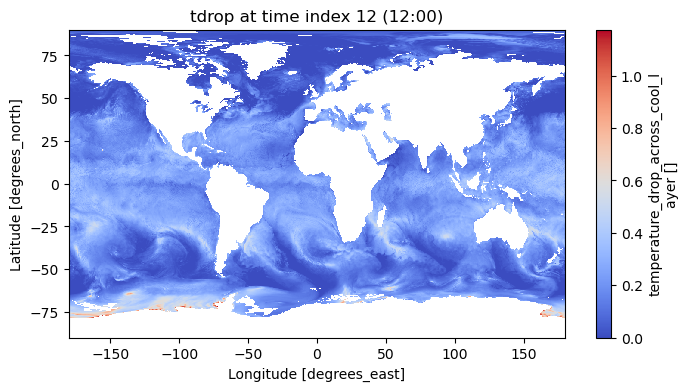

In [2]:
t_index = 12  # Noon
plt.figure(figsize=(8, 4))
ds_2018["tdrop"][t_index].plot(cmap="coolwarm")
plt.title(f"tdrop at time index {t_index} (12:00)")
plt.show()


# Model and training

For this regression task, I chose **Gaussian Process Regression (GPR)**.  
GPR is a powerful and interpretable non-parametric model that is especially well-suited for modeling spatial and environmental data. It not only provides predictions, but also quantifies how uncertain those predictions are, a key feature when working with climate-related variables.


Unlike classical regression methods (e.g., linear or polynomial), which assume a fixed form for the function we are modeling, GPR places a probability distribution over all possible functions that could fit the data.

At its core, GPR applies the **Bayes’ theorem** at the level of functions:

$$
P(f(x) \mid \mathcal{D}) = \frac{P(\mathcal{D} \mid f(x)) \cdot P(f(x))}{P(\mathcal{D})}
$$

Where:
- $ f(x) $ is the function wea re trying to learn,
- $ \mathcal{D} = \{X, y\} $ is our training data,
- $ P(f(x)) $ is the prior over functions,
- $ P(\mathcal{D} \mid f(x)) $ is the likelihood of seeing the data given a function,
- $ P(f(x) \mid \mathcal{D}) $ is the posterior: the updated belief about functions after seeing the data.



The **prior** is defined using a Gaussian Process, which is a distribution over functions such that the values of the function at any finite set of points follow a multivariate Gaussian distribution:
$$
f(x) \sim \mathcal{GP}(\mu(x), k(x, x'))
$$
where:
- $ \mu(x) $ is the mean function (usually set to 0)
- $ k(x, x')$ is the kernel function, defining how similar inputs are correlated

So for a finite set of inputs $ X = \{x_1, x_2, \dots, x_n\} $, the prior becomes:
$$
f(X) \sim \mathcal{N}\left(0, K(X, X)\right)
$$
This is a multivariate normal distribution over function values:
- the covariance matrix $ K(X, X) $ encodes pairwise similarities between inputs,
- the entries of $ K $ are defined by a kernel: $ K_{ij} = k(x_i, x_j) $.




We assume we do not observe the true function values $ f(X) $ directly; instead, we observe **noisy measurements**:
$$
y = f(X) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma_n^2 I)
$$
So the **likelihood** becomes:
$$
y \sim \mathcal{N}(0, K(X, X) + \sigma_n^2 I)
$$
Here:
- $ \sigma_n^2 $ is the observation noise variance,
- $ I $ is the identity matrix (adds independent noise to each point).



The **kernel (or covariance function)** defines how inputs influence each other, that is, how much knowing the function value at $ x_i $ tells us about $ x_j$.

Here, we use the **Radial Basis Function (RBF) kernel**, also known as the squared exponential:
$$
k(x_i, x_j) = \exp\left( -\frac{1}{2 \ell^2} \|x_i - x_j\|^2 \right)
$$
where:
- $ \ell $ is the length scale and set how far inputs need to be before they become uncorrelated,
- $ \|x_i - x_j\| $ is the Euclidean distance between two input vectors.

Key properties:
- smoothness: RBF assumes the underlying function is infinitely differentiable,
- stationarity: it depends only on the distance  $|x_i - x_j\| $, not their absolute positions.

In this project, the RBF kernel makes sense because we expect smooth and gradual changes in ocean-related variables across space and time.



Using rules for conditioning Gaussians, the predictive distribution for a test input \( x_* \) is:
- mean:
  $$
  \mu(x_*) = K(x_*, X)[K(X, X) + \sigma_n^2 I]^{-1} y
  $$

- variance:
  $$
  \sigma^2(x_*) = K(x_*, x_*) - K(x_*, X)[K(X, X) + \sigma_n^2 I]^{-1}K(X, x_*)
  $$

This gives us not only a point prediction, but also a measure of uncertainty around it.

In [4]:
import xarray as xr
import numpy as np
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
import joblib
import os

def train_and_save_gpr_model():
    print("Training GPR model...")

    # Load 2018 dataset
    data_2018 = 'OCEAN_RELATED_DATA/2018/tavg1_2d_ocn_Nx-202109201458output.17833.webform.nc4'
    ds_2018 = xr.open_dataset(data_2018)

    # Variables and parameters
    features = ['tbar', 'tskinice', 'rainocn', 'delts']
    target = 'tdrop'
    time_steps = [0, 4, 8, 12, 16, 20]
    lat_subsample = 10
    lon_subsample = 10

    # Prepare training data
    X_train, y_train = [], []
    for t in time_steps:
        for lat in range(0, len(ds_2018.latitude), lat_subsample):
            for lon in range(0, len(ds_2018.longitude), lon_subsample):
                f_vals = [ds_2018[var][t, lat, lon].item() for var in features]
                if not any(np.isnan(f_vals)):
                    X_train.append(f_vals)
                    y_train.append(ds_2018[target][t, lat, lon].item())

    MAX_SAMPLES = 5000 #it can be smaller, but higher values make it computationally very expensive
    if len(X_train) > MAX_SAMPLES:
        idx = random.sample(range(len(X_train)), MAX_SAMPLES)
        X_train = [X_train[i] for i in idx]
        y_train = [y_train[i] for i in idx]

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    print(f"Training samples: {X_train.shape}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.01, normalize_y=True)
    gpr.fit(X_train_scaled, y_train)

    joblib.dump(gpr, "gpr_model.pkl")
    joblib.dump(scaler, "gpr_scaler.pkl")
    print("Model and scaler saved")

    return gpr, scaler

# Optional: make it runnable standalone
if __name__ == "__main__":
    train_and_save_gpr_model()

Training GPR model...
Training samples: (5000, 4)


/home/sara/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Model and scaler saved


Note: 